In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import itertools
import importlib
import config
importlib.reload(config)
from config import BIN_SIZE as bin_size
from config import ANALYSIS_MODE as analysis_mode
from config import SPECIFIC_GROUP as specific_group
from config import STRATIFY_BY as stratify

# 1. Loading of Dataframes

In [20]:
print(analysis_mode)
print(specific_group)
print(bin_size)

matrix_path = f"/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/final_feature_matrix_gc_corrected_{bin_size}.tsv"
df = pd.read_csv(matrix_path, sep="\t")

clinical_path = "/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/filtered_clinical_characteristics.csv"
clinical_df_raw = pd.read_csv(clinical_path, sep=";")

if analysis_mode == "specific_vs_healthy":
    clinical_df = clinical_df_raw[
            (clinical_df_raw["Patient Type"] == specific_group) |
            (clinical_df_raw["Patient Type"].str.lower() == "healthy")
        ].copy()
else:
    clinical_df = clinical_df_raw.copy()

if stratify =="Gender":
    clinical_df = clinical_df[clinical_df["Gender"].isin(["M", "F"])]
else:
    clinical_df = clinical_df
# Balancing: Sample as many Healthy as there are Cancer samples
cancer_df = clinical_df[clinical_df["Patient Type"].str.lower() != "healthy"]
print(cancer_df.shape)
healthy_df = clinical_df[clinical_df["Patient Type"].str.lower() == "healthy"]
print(healthy_df.shape)
n_cancer = len(cancer_df)

healthy_df = healthy_df.sample(n=n_cancer, random_state=42)
clinical_df = pd.concat([cancer_df, healthy_df]).copy()
print(len(healthy_df))
print(len(cancer_df))

valid_samples = clinical_df["Extracted_ID"].unique()
df = df[df["sample"].isin(valid_samples)].copy()

print(f"Number of Samples in Matrix: {df['sample'].nunique()}")
print(f"Number of Bins per Sample: {len(df) / df['sample'].nunique()}")


all_vs_healthy
Pancreatic Cancer
50000
(115, 19)
(129, 19)
115
115
Number of Samples in Matrix: 230
Number of Bins per Sample: 4260.0


# 2. Pipeline for LASSO

In [21]:
C_values = np.logspace(-2, 2, 50)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('lasso_cv', LogisticRegressionCV(
        Cs=C_values,
        penalty='l1',
        solver='liblinear',
        cv=5,
        scoring='roc_auc',
        max_iter=10000,
        random_state=42
    ))
])

# 3. General Function for LASSO perfomance

In [ ]:
def run_lasso_for_metrics(df, clinical_df, metrics, pipeline):
    # Pivot
    pivot_df = df.pivot(
        index="sample",
        columns="bin_id",
        values=list(metrics)
    )
    pivot_df.columns = [
        f"{metric}_{bin_id}" for metric, bin_id in pivot_df.columns
    ]

    # Labels and Stratification
    y = []
    strata = []

    for sample_id in pivot_df.index:
        row = clinical_df[clinical_df["Extracted_ID"] == sample_id].iloc[0]
        
        is_healthy = row["Patient Type"].lower() == "healthy"
        target_val = 0 if is_healthy else 1
        y.append(target_val)
        
        if stratify == "Gender":
            strata.append(row["Gender"])
        else:
            strata.append(target_val)

    y = np.array(y)
    X = pivot_df

    print(f"Number Cancer: {sum(y)}")
    print(f"Number Healthy: {len(y) - sum(y)}")

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,
        stratify=strata,
        random_state=42
    )

    # Fit
    pipeline.fit(X_train, y_train)

    # Predict
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)

    # Coefficients
    lasso_model = pipeline.named_steps['lasso_cv']
    n_selected = np.sum(lasso_model.coef_[0] != 0)

    return {
        "metrics": metrics,
        "n_metrics": len(metrics),
        "n_features": X.shape[1],
        "n_selected_features": int(n_selected),
        "roc_auc": auc_score,
        "best_C": lasso_model.C_[0]
    }


# 4. Feature Selektion for LASSO (combinations of metrics)

In [ ]:
df["bin_id"] = df["chrom"] + "_" + df["start"].astype(str)

metrics = [
    "mean", 
    "median", 
    "stdev", 
    "wps_value",
    "min",
    "max",	
]

metrics_results =[]

for r in range (1, len(metrics) + 1):
    for combination in itertools.combinations(metrics, r):
        res = run_lasso_for_metrics(df, clinical_df, combination, pipeline)
        metrics_results.append(res)

print(pd.DataFrame(metrics_results).columns)
print(metrics_results[0].keys())

metrics_results = pd.DataFrame(metrics_results).sort_values("roc_auc", ascending=False)
metrics_results.to_csv("/labmed/workspace/lotta/finaletoolkit/dataframes_notebooklasso_metrics_results.csv", index=False)

print("10 Best metric combinations:")
print(metrics_results.head(10))

best_metrics = metrics_results.iloc[0]['metrics']
print("Best metrics:", best_metrics)


Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number

# 5. Influence of metric selection on model performance

<AxesSubplot:title={'center':'Mean ROC AUC vs Number of Metrics'}, xlabel='Number of Metrics', ylabel='ROC AUC'>

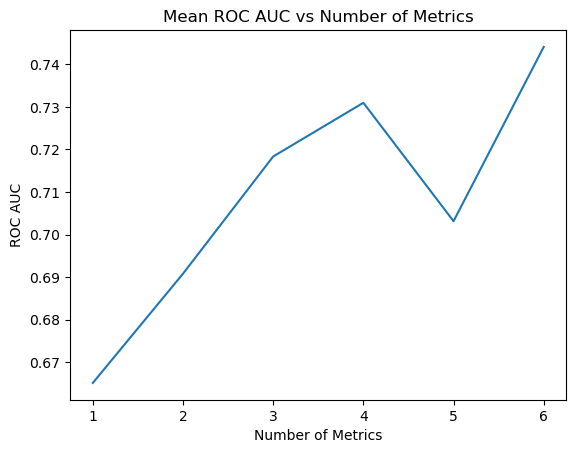

In [24]:
metrics_with_wps.groupby("n_metrics")["roc_auc"].mean().plot(
    title="Mean ROC AUC vs Number of Metrics",
    ylabel="ROC AUC",
    xlabel="Number of Metrics"
)

### 5.1 Lasso Modeling with best C parameter 

The `LogisticRegressionCV` model automatically tried out different values for the parameter `C`. 
Here we visualize how the accuracy of the model changes with `C`.

- **Small C**: Strong regularization (model is “forced” to find simple solutions). Risk of underfitting.
- **Large C**: Weak regularization (model can be more complex). Risk of overfitting.
- **Best C**: The value that achieved the best balance and thus the highest score in cross-validation (CV).

The Reciever operating characteristic curve plots the true positive (TP) rate versus the false positive (FP) rate at different classification thresholds. 

The thresholds are different probability cutoffs that separate the two classes in binary classification. It uses probability to tell us how well a model separates the classes.

Re-training model with best metrics: ('mean', 'median', 'stdev')


Best C (max mean): 68.664885 with AUC: 0.7586
c_1se (parsimonious): 0.065513 (Threshold: 0.7335)


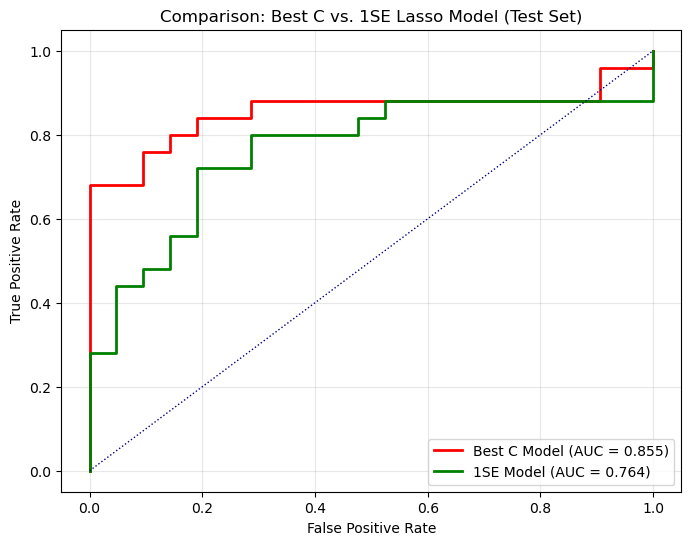

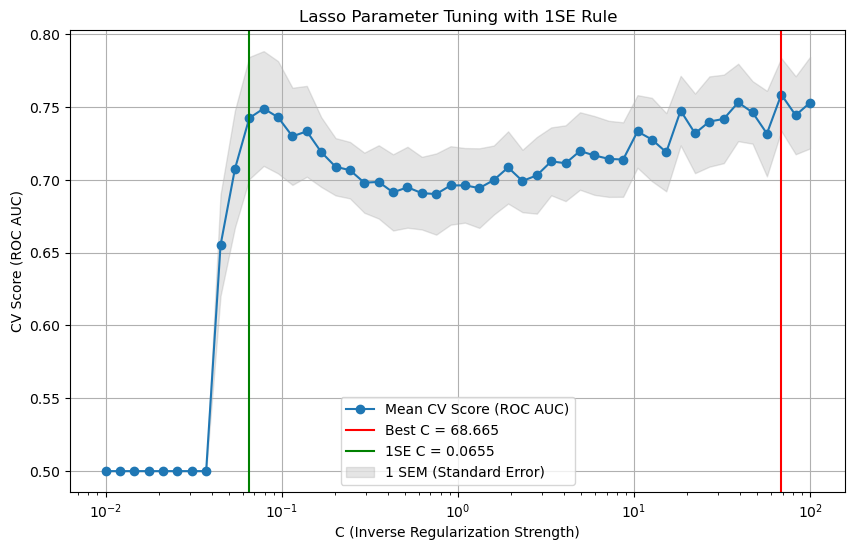

In [ ]:
print(f"Re-training model with best metrics: {best_metrics}")

# Pivot
pivot_df = df.pivot(
    index="sample",
    columns="bin_id",
    values=list(best_metrics)
)
pivot_df.columns = [
    f"{metric}_{bin_id}" for metric, bin_id in pivot_df.columns
]

# Labels
y = []
strata = []
for sample_id in pivot_df.index:
    row = clinical_df[clinical_df["Extracted_ID"] == sample_id].iloc[0]
    is_healthy = row["Patient Type"].lower() == "healthy"
    target_val = 0 if is_healthy else 1
    y.append(target_val)
    if stratify == "Gender":
        strata.append(row["Gender"])
    else:
        strata.append(target_val)

y = np.array(y)
X = pivot_df

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=strata,
    random_state=42,
)

# Fit
pipeline.fit(X_train, y_train)


# --- 1se Rule Calculation ---
# scores_[1] is of shape (n_folds, n_Cs)
mean_scores = np.mean(lasso_cv.scores_[1], axis=0)
std_scores = np.std(lasso_cv.scores_[1], axis=0)
n_folds = 5
sem_scores = std_scores / np.sqrt(n_folds)
cs = lasso_cv.Cs_

best_idx = np.argmax(mean_scores)
best_c = float(cs[best_idx])
best_score = mean_scores[best_idx]
best_sem = sem_scores[best_idx]
threshold = best_score - best_sem

# c_1se: smallest C (most parsimonious) within 1 SEM of maximum
idx_1se = np.where(mean_scores >= threshold)[0][0]
c_1se = float(cs[idx_1se])

print(f"Best C (max mean): {best_c:.6f} with AUC: {best_score:.4f}")
print(f"c_1se (parsimonious): {c_1se:.6f} (Threshold: {threshold:.4f})")


# 1. Calculate probabilities for both models (Test Set)
y_prob_best = pipeline.predict_proba(X_test)[:, 1]
y_prob_1se = stable_pipeline.predict_proba(X_test)[:, 1]

# 2. Calculate ROC values for both models
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)
fpr_1se, tpr_1se, _ = roc_curve(y_test, y_prob_1se)

auc_best = roc_auc_score(y_test, y_prob_best)
auc_1se = roc_auc_score(y_test, y_prob_1se)

# 3. Create Common Plot
plt.figure(figsize=(8, 6))

# Curve 1: Best C (e.g., in Blue)
plt.plot(fpr_best, tpr_best, color='red', lw=2, 
         label=f'Best C Model (AUC = {auc_best:.3f})')

# Kurve 2: 1SE Model (z.B. in Grün oder Orange)
plt.plot(fpr_1se, tpr_1se, color='green', lw=2,
         label=f'1SE Model (AUC = {auc_1se:.3f})')

# Diagonale (Zufallslinie)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle=':')

plt.title('Comparison: Best C vs. 1SE Lasso Model (Test Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.show()

# --- Lasso Parameter Tuning Plot ---
plt.figure(figsize=(10,6))
plt.semilogx(cs, mean_scores, marker='o', label='Mean CV Score (ROC AUC)')
plt.fill_between(cs, mean_scores - sem_scores, mean_scores + sem_scores, alpha=0.2, color='gray', label='1 SEM (Standard Error)')
plt.axvline(best_c, color='r', label=f'Best C = {best_c:.3f}')
plt.axvline(c_1se, color='g', label=f'1SE C = {c_1se:.4f}')
plt.title("Lasso Parameter Tuning with 1SE Rule")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("CV Score (ROC AUC)")
plt.legend()
plt.grid(True)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/lasso_parameter_tuning{bin_size}.png")
plt.show()

## 5.2 Training vs. Test with best model 

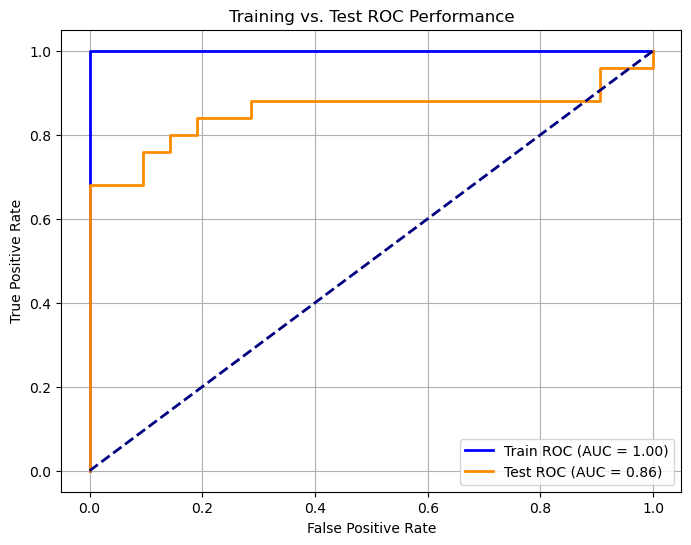

In [26]:
y_prob_train = pipeline.predict_proba(X_train)[:, 1]
y_prob_test = pipeline.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

plt.figure(figsize=(8, 6))
auc_train = roc_auc_score(y_train, y_prob_train)
auc_test = roc_auc_score(y_test, y_prob_test)
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Training vs. Test ROC Performance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 5.3 Training vs. Test with 1SE Model

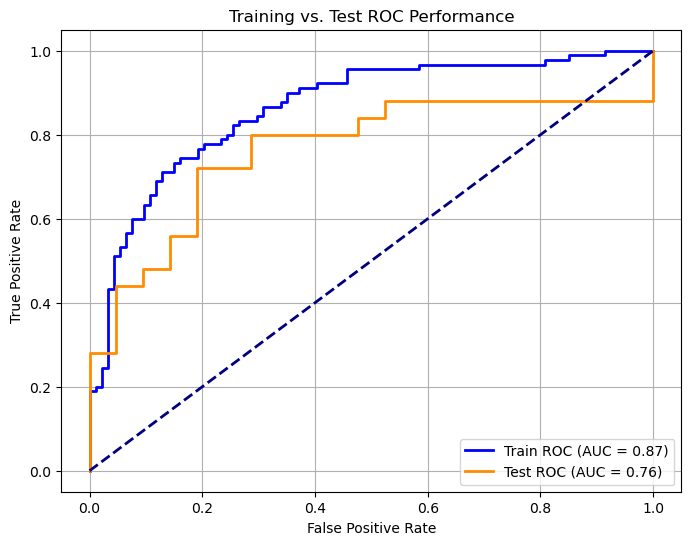

In [28]:
y_prob_train = stable_pipeline.predict_proba(X_train)[:, 1]
y_prob_test = stable_pipeline.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

auc_train = roc_auc_score(y_train, y_prob_train)
auc_test = roc_auc_score(y_test, y_prob_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Training vs. Test ROC Performance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 6. Selected Important Features


## 6.1 Pipeline with best model

In [ ]:
from cv_lasso_single_fold import cross_validation, analyze_feature_stability, plot_roc_curves, plot_auc_boxplot

# --- A. Single Model Analysis (Current Split) ---
lasso_model = pipeline.named_steps['lasso_cv']

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso_model.coef_[0]
})
important_features = coef_df[coef_df["Coefficient"] != 0].sort_values(by="Coefficient", ascending=False)

print("SINGLE MODEL (Best C)")
print(f"Number of Important Features (Single Model): {len(important_features)}")
print("\nTop Features (Single Model - Positive = Indicative for Cancer):")
print(important_features.head(20))

SINGLE MODEL (Best C)
Number of Important Features (Single Model): 1101

Top Features (Single Model - Positive = Indikative for Cancer):
                      Feature  Coefficient
10660    stdev_chr1_248500000     0.389190
4745   median_chr12_108700000     0.386980
6195    median_chr1_151600000     0.380968
9615     stdev_chr16_18450000     0.361868
12285    stdev_chr7_135950000     0.355109
4630    median_chr11_63450000     0.333693
6776    median_chr22_31750000     0.308274
10757     stdev_chr1_53850000     0.293312
11450    stdev_chr3_138150000     0.293017
6179    median_chr1_149800000     0.277602
11767     stdev_chr4_82850000     0.266580
3713      mean_chr7_100800000     0.265470
370       mean_chr11_63450000     0.244267
12394     stdev_chr7_63750000     0.243054
6993    median_chr2_230050000     0.239087
344        mean_chr11_5750000     0.236234
10479    stdev_chr1_156100000     0.234345
12012     stdev_chr6_12000000     0.232580
5868     median_chr19_1100000     0.232529
101

## 6.2 Stable Pipeline with 1SE model 


In [ ]:

stable_lasso_model = stable_pipeline.named_steps['model']

stable_coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": stable_lasso_model.coef_[0]
})

stable_important_features = stable_coef_df[stable_coef_df["Coefficient"] != 0].sort_values(by="Coefficient", ascending=False)

print("STABLE MODEL (c_1se):")
print(f"Number of Important Features (Stable Model): {len(stable_important_features)}")
print(f"\nTop Features (Stable Model - Positive = Indicative for Cancer):")
print(stable_important_features.head(20))

print("\n")
print("COMPARISON:")
print(f"Best C Model: {len(important_features)} features selected")
print(f"1SE Model:    {len(stable_important_features)} features selected")
print(f"Difference:   {len(important_features) - len(stable_important_features)} fewer features in 1SE model")

STABLE MODEL (c_1se):
Number of Important Features (Stable Model): 8

Top Features (Stable Model - Positive = Indicative for Cancer):
                    Feature  Coefficient
2457    mean_chr21_43350000    -0.024817
1523     mean_chr18_1350000    -0.045798
6158   median_chr1_12850000    -0.053993
360     mean_chr11_61800000    -0.074044
5783   median_chr18_1350000    -0.089475
1921      mean_chr1_1500000    -0.099877
801    mean_chr14_104100000    -0.194890
12299  stdev_chr7_149100000    -0.388639


COMPARISON:
Best C Model: 1101 features selected
1SE Model:    8 features selected
Difference:   1093 fewer features in 1SE model


# 7. Feature Stability Analysis (Cross-Validation) 


Running 5-Fold Cross-Validation for Feature Stability.
Fold 1/5...


  AUC = 0.817, Best C = 100.0
Fold 2/5...
  AUC = 0.877, Best C = 68.66488450042998
Fold 3/5...
  AUC = 0.871, Best C = 100.0
Fold 4/5...
  AUC = 0.836, Best C = 1.5998587196060574
Fold 5/5...
  AUC = 0.858, Best C = 39.06939937054613


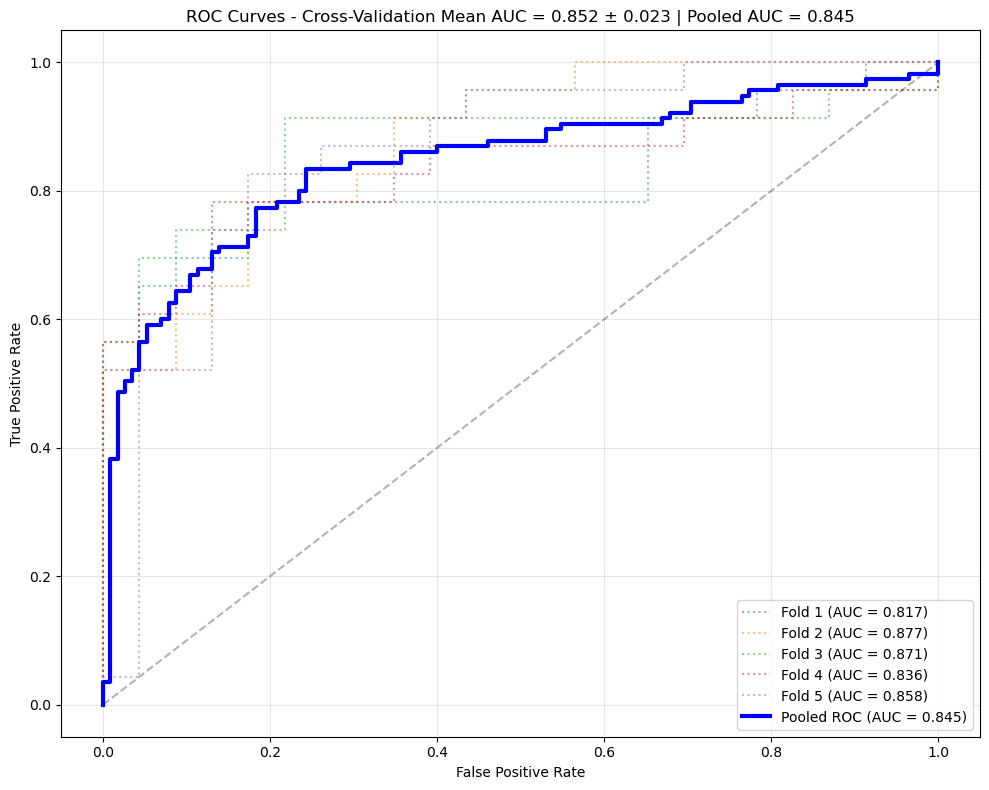

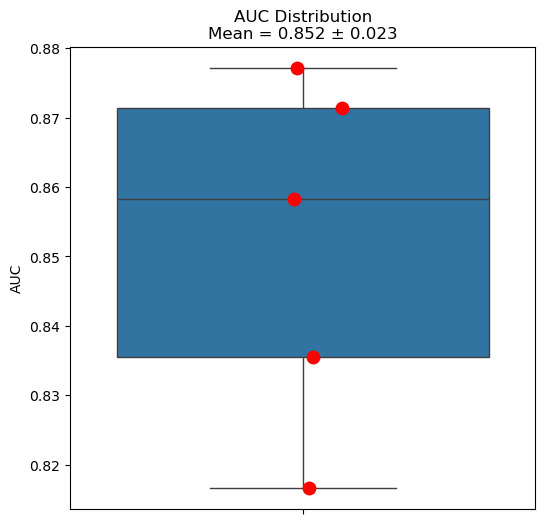

Number of Stable Features (Selected across multiple folds): 52

Top Stable Features (Selected across multiple folds):
                    Feature  Frequency  Frequency_Percent  Mean_Coef
150     mean_chr19_37450000          5              100.0   0.437109
213     mean_chr21_34450000          5              100.0   0.400304
342   median_chr11_63450000          5              100.0   0.396323
641    stdev_chr16_18450000          5              100.0   0.368441
461   median_chr1_149800000          5              100.0   0.331856
770    stdev_chr3_138150000          5              100.0   0.322115
14      mean_chr10_80200000          5              100.0   0.317944
722    stdev_chr1_248500000          5              100.0   0.314811
504    median_chr2_68800000          5              100.0   0.310384
348  median_chr12_108700000          5              100.0   0.278018
756    stdev_chr2_219200000          5              100.0   0.252198
171     mean_chr1_149800000          5              10

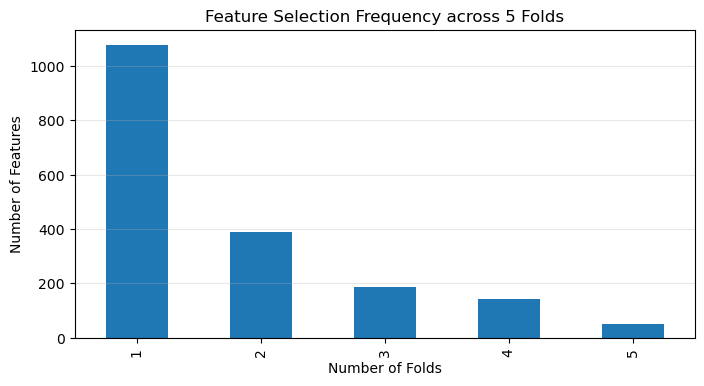

Features in ALL 5 folds: 52


In [ ]:
import importlib
import cv_lasso_single_fold
importlib.reload(cv_lasso_single_fold)
from cv_lasso_single_fold import plot_roc_curves
print("Running 5-Fold Cross-Validation for Feature Stability.")

# X and y should be available from previous cells. 
# We use X (full pivot_df before split if available, or regenerate if needed).
# Assuming X and y are the full datasets as defined before train_test_split.

# Re-verify label consistency
# hier macht es keinen sinn die stable pipeline zu nutzen, da in jedem fold mit dem gleichen c wert (c_1se) trainiert wird
cv_results = cross_validation(X, y, pipeline, n_folds=5)

# Plotte Performance
plot_roc_curves(cv_results)
plot_auc_boxplot(cv_results)

# Feature Stability Analyse
stability_df = analyze_feature_stability(cv_results)
n_folds = 5
stable_in_all = stability_df[stability_df['Frequency'] == n_folds]
anzahl_stable = len(stable_in_all)
print("Number of Stable Features (Selected across multiple folds):", anzahl_stable)
print("\nTop Stable Features (Selected across multiple folds):")
print(stability_df.head(5))

# Histogram
plt.figure(figsize=(8, 4))
stability_df['Frequency'].value_counts().sort_index().plot(kind='bar')
plt.title('Feature Selection Frequency across 5 Folds')
plt.xlabel('Number of Folds')
plt.ylabel('Number of Features')
plt.grid(axis='y', alpha=0.3)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/roc_curve_{bin_size}_fold.png")
plt.show()
print(f"Features in ALL 5 folds: {len(stable_in_all)}")

# 8. Visualize the ROC Calculation (Label, Probability)

In [ ]:
# 1. Get the probabilities for the test set 
y_prob_test = pipeline.predict_proba(X_test)[:, 1]

# 2. Create a DataFrame to map predictions to sample IDs
test_results = pd.DataFrame({
    'Sample_ID': X_test.index,
    'True_Label': y_test,
    'Probability_Cancer': y_prob_test
})

# 3. Sort the results by probability    
test_results = test_results.sort_values(by='Probability_Cancer', ascending=False).reset_index(drop=True)

# 4. Print the top 5 predictions
print("Detailed predicitions for test set:")
print(test_results.head(5))


Detailed predicitions for test set:
   Sample_ID  True_Label  Probability_Cancer
0    EE88325           1        9.999412e-01
1    EE87873           1        9.997424e-01
2    EE87809           1        9.988901e-01
3    EE87888           1        9.986990e-01
4    EE88295           1        9.986514e-01
5    EE87913           1        9.984260e-01
6    EE87806           1        9.978049e-01
7    EE88303           1        9.977358e-01
8    EE88298           1        9.968711e-01
9    EE88312           1        9.960019e-01
10   EE87886           1        9.862879e-01
11   EE88294           1        9.853348e-01
12   EE88323           1        9.846705e-01
13   EE87897           1        9.759527e-01
14   EE87865           1        9.743943e-01
15   EE87794           1        9.567488e-01
16   EE87896           1        9.357215e-01
17   EE87956           0        7.851951e-01
18   EE87989           0        7.376785e-01
19   EE88302           1        4.171574e-01
20   EE87807       

In [33]:
# Falsch-Negative (Krebs als gesund vorhergesagt)
fn_proben = test_results[(test_results['True_Label'] == 1) & (test_results['Probability_Cancer'] < 0.3)]

# Falsch-Positive (Gesund als Krebs vorhergesagt)
fp_proben = test_results[(test_results['True_Label'] == 0) & (test_results['Probability_Cancer'] > 0.7)]

# Merge outliers with test_results to get the probabilities
outliers_meta = pd.concat([fn_proben, fp_proben])
if not outliers_meta.empty:
    ausreisser_klinik = clinical_df.merge(outliers_meta[['Sample_ID', 'Probability_Cancer', 'True_Label']], 
                                         left_on='Extracted_ID', right_on='Sample_ID')
    print(f"Found outliers with threshold (FN < 0.3, FP > 0.7): {len(ausreisser_klinik)}")
    print(ausreisser_klinik[['Extracted_ID', 'Patient Type', 'Gender', 'Probability_Cancer']])
else:
    print("No outliers found.")


Found outliers with threshold (FN < 0.3, FP > 0.7): 8
  Extracted_ID       Patient Type Gender  Probability_Cancer
0      EE87876  Colorectal Cancer      F        1.919729e-01
1      EE87883  Colorectal Cancer      M        2.127146e-01
2      EE87902     Gastric cancer      M        7.444877e-22
3      EE87906     Gastric cancer      M        9.232897e-02
4      EE87914     Gastric cancer      M        1.233866e-03
5      EE86270  Pancreatic Cancer      M        7.790896e-04
6      EE87989            Healthy      M        7.376785e-01
7      EE87956            Healthy      F        7.851951e-01
